In [14]:
import cv2
import imutils
import numpy as np
import cupy as cp
import math
from os import listdir
from os.path import isfile, join
import io
from IPython.display import display
from PIL import Image
from skimage.exposure import match_histograms
from cupyx.scipy import ndimage
import os

z_step_counter = 0


import import_ipynb

import time
from sklearn.model_selection import train_test_split

In [23]:
#%run ../variables.ipynb
%run utils.ipynb
%run ../image_utils.ipynb
%run ../generator_voc/data_utils.ipynb
%run ../global_variables.ipynb
%run zstack.ipynb
%run ../utils.ipynb

In [16]:
SAVE_TO_TMP = False

ROOT = '/home/souhila/nvme-storage/data/'
#path destination
DATASET_PATH_TRAINVAL = os.path.join(ROOT + 'artificial/train_artificial/')
DATASET_PATH_TRAIN = os.path.join(DATASET_PATH_TRAINVAL + 'train/')
DATASET_PATH_VAL = os.path.join(DATASET_PATH_TRAINVAL + 'val/')
DATASET_PATH_TEST = os.path.join(ROOT + 'artificial/test_artificial/')

#
DATASET_PATH = [os.path.join(ROOT + 'origin/train_origin/train/')]
DATASET_DUST_PATH = [os.path.join(ROOT + 'origin/DUST/')]
PERCENTAGE_VAL = 0.1

In [17]:
def pick_images(images_dict, n_range=[9,12]):
    # Pick random images and add them to list
    n = np.random.randint(n_range[0], n_range[1])
    rand_images = []
    for i in range(n):
        # choosing random images
        rand_key = np.random.choice(list(images_dict.keys()))
        rand_indice = np.random.randint(len(images_dict[rand_key]))
        #rand_image_path = images_dict[rand_key][rand_indice]
        # loading image
        #image_path = join(rand_image_path[0], rand_image_path[1])
        #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if SAVE_TO_TMP: 
            tmp_path = os.path.join(OUTPUT_TMP, "thumbnails/"+rand_key+str(i)+".png")
            check_dirs(tmp_path)
            cv2.imwrite(tmp_path, img)
        #img = match_histograms(img, ref, multichannel=False).astype("uint8")
        #img = cp.asarray(img)
        rand_images.append({"data":images_dict[rand_key][rand_indice], "taxon":rand_key})
    return rand_images

In [18]:
def patchwork(tmp_images, simple_angles = True, size_px = 1000, overlapping=0, starter=None, scale=[5,5]):
    art_img = (cp.ones((size_px, size_px))).astype(np.uint8)
    if starter is None:
        global_patch = cp.zeros_like(art_img)
        global_patch_mask_rogn = cp.zeros_like(art_img)
        individual_patches = []
    else:
        global_patch = starter[0]
        global_patch_mask_rogn = starter[1]
        individual_patches = starter[2]
    annotations = []
    global z_step_counter
    for img_obj in tmp_images:
        w, h = img_obj["data"].shape
        #rand_scale = np.random.randint(10, 20)/100
        rand_scale = (scale[0]+np.random.exponential(scale[1]))/100
        ratio = (rand_scale*size_px)/np.mean([w,h])
        img = ndimage.zoom(img_obj["data"], ratio)
        w, h = img.shape
        mask = cp.ones_like(img)*255
        ask_rogn = mask
        mask_rogn = cp.asarray(round_rectangle(np.min([w,h])//2, w, h, value=255).astype("uint8"))
        # Flipping
        
        if np.random.random()<0.5:
            img = cp.flip(img, 0)
        if np.random.random()<0.5:
            img = cp.flip(img, 1)
        # Rotating
        if simple_angles:
            angle = np.random.choice((0,90))
        else:
            angle = np.random.randint(0,360)

        rotated = ndimage.rotate(img, angle, axes=(1, 0), reshape=True, output=None, order=None, mode='constant', cval=0.0, prefilter=True)
        #rotated_mask = cpx.scipy.ndimage.rotate(mask, angle, axes=(1, 0), reshape=True, output=None, order=None, mode='constant', cval=0.0, prefilter=True)
        rotated_mask_rogn = ndimage.rotate(mask_rogn, angle, axes=(1, 0), reshape=True, output=None, order=None, mode='constant', cval=0.0, prefilter=True)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        #overlap_test = float("inf")
        overlapping_test = True
        n_stop = 200
        area = w*h
        #while overlap_test>area*overlapping and n_stop != 0:
        while overlapping_test and n_stop != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = np.random.randint(0,size_px-1), np.random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = cp.zeros_like(art_img)
            patch_mask = cp.zeros_like(art_img)
            patch_mask_rogn = cp.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            #patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask_rogn[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask_rogn[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            #overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask_rogn))[0])
            overlapping_test=False
            for prev_patch in individual_patches:
                prev_patch_mask = prev_patch["patch_mask"]
                n_overlapping_pixels = len(cp.nonzero(cp.logical_and(patch_mask_rogn, prev_patch_mask))[0])
                n_pixels_prev_patch = len(cp.nonzero(prev_patch_mask)[0])
                n_pixels_patch = len(cp.nonzero(patch_mask_rogn)[0])
                if n_overlapping_pixels>=overlapping*n_pixels_prev_patch or n_overlapping_pixels>=overlapping*n_pixels_patch:
                    overlapping_test=True
                    break;
            n_stop -= 1
        if n_stop > 0:
            individual_patches.append({
                "patch": patch.copy(), 
                "patch_mask": patch_mask_rogn.copy(), 
                "center": (int(math.ceil((np.mean([ymin+dymin, ymax+dymax])))), int(math.ceil((np.mean([xmin+dxmin, xmax+dxmax])))))})
            # (erosion to get rid of black edges)
            #kernel_size = 3
            #kernel = cp.ones((kernel_size,kernel_size),np.uint8)
            #patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
            #patch_mask_rogn = cv2.erode(patch_mask_rogn,kernel,iterations = 1)
            # filling global patches
            #cp.copyto(patch, patch_mask_rogn, global_patch)
            #cp.copyto(patch_mask_rogn, patch_mask_rogn, global_patch_mask_rogn)
            global_patch += patch
            global_patch_mask_rogn += patch_mask_rogn
            #patch_mask_rogn[patch_mask_rogn>0]=1
            annotations.append({
                "taxon": img_obj["taxon"],
                "ymin": xmin+dxmin,
                "xmin": ymin+dymin,
                "ymax": xmax+dxmax,
                "xmax": ymax+dymax,
                "patch_mask": patch_mask_rogn,
                "z_index": z_step_counter
                
            })
            z_step_counter+=1
        else:
            pass
            #print("Image eliminated...")
    #CREATING FINAL IMAGE
    art_img += global_patch
    #cp.copyto(global_patch, global_patch_mask_rogn, art_img)
    if SAVE_TO_TMP: 
        tmp_patch = cv2.cvtColor(global_patch,cv2.COLOR_GRAY2RGB)
        conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        tmp_patch = cv2.drawContours(tmp_patch, conts, -1, (0,0,255), 3)
        cv2.imwrite(os.path.join(OUTPUT_TMP, "global_patch.png"), tmp_patch)
    return global_patch, global_patch_mask_rogn, annotations, individual_patches

In [19]:
def fast_img_filling(global_patch, global_patch_mask_rogn, individual_patches, sigma=10e3, verbose=False):
    # IMPROVED img_filling USING CUPY
    final_img = global_patch.copy()
    acc, accw = cp.zeros_like(final_img).astype(np.float32), cp.zeros_like(final_img).astype(np.float32)
    # Finding contours
    conts, h = cv2.findContours(cp.asnumpy(global_patch_mask_rogn), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    height=global_patch.shape[0]
    width=global_patch.shape[1]
    if not hasattr(fast_img_filling, 'W'):
        indices = np.indices((height*2,width*2))
        xMap = cp.asarray(indices[0])
        yMap = cp.asarray(indices[1])
        d2 = cp.square(xMap - width) + cp.square(yMap - height)
        fast_img_filling.W = cp.exp(-d2/sigma)
        fast_img_filling.W[fast_img_filling.W<1e-10] = 1e-10
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
            i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        w = fast_img_filling.W[height-ykp:2*height-ykp,width-xkp:2*width-xkp]
        acc += w*val
        accw += w
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    
    # sticking the diatoms
    tmp_global_patch_mask_null = global_patch_mask_rogn==0
    dst = expand(cp.asnumpy(acc_img))
    if SAVE_TO_TMP: cv2.imwrite(os.path.join(OUTPUT_TMP, "gradient.png"), dst)
    center = (height//2, width//2)
    np.random.shuffle(individual_patches)
    for patch in individual_patches:
        ks = np.floor(abs(np.random.normal(0, 3, 1))).astype("uint8")[0]*2+1
        patch_img = cp.asnumpy(patch["patch"])
        patch_img = cv2.GaussianBlur(patch_img,(ks,ks),0)
        src = expand(patch_img)
        mask = cp.asnumpy(patch["patch_mask"])
        center = patch["center"]
        try:
            dst = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
        except ValueError:
            print("hey")
    return dst


In [20]:
def voc_writer(DATASET_PATH, img, xmin, ymin, xmax, ymax):
    # Writer(path, width, height)

    writer = Writer(os.path.join(DATASET_PATH + img + '.png'), 1000, 1000)

    # ::addObject(name, xmin, ymin, xmax, ymax)
    for objet in objets:
        writer.addObject('diatoms', xmin, ymin, xmax, ymax)

    # ::save(path)

    writer.save(os.path.join(DATASET_PATH + img + '.xml'))


In [21]:
def main_generator(images, simple_angles = False, size_px = 1000, verbose=False, overlapping=0, number_overlapping=1, n_diatoms=[9,12], scale_diatoms=[1,1], n_dust=[15,30], scale_dust=[5,10]):    
    # Placing them randomly on the artboard
    global z_step_counter
    z_step_counter = 0
    images_dict_diatoms, images_dict_debris = images
    
    # Diatoms
    rand_images_diatoms = pick_images(images_dict_diatoms, n_diatoms)
    global_patch, global_patch_mask_rogn, annotations, individual_patches = patchwork(rand_images_diatoms, 
                                                                  simple_angles=simple_angles, 
                                                                  size_px=size_px, 
                                                                  overlapping=overlapping,
                                                                  scale=scale_diatoms)
    # Debris
    if not n_dust is None: 
        rand_images_debris = pick_images(images_dict_debris, n_dust)
        global_patch, global_patch_mask_rogn, annotations_dust, individual_patches = patchwork(rand_images_debris, 
                                                  simple_angles=simple_angles, 
                                                  size_px=size_px, 
                                                  overlapping=0, 
                                                  starter=[global_patch, global_patch_mask_rogn, individual_patches],
                                                  scale=scale_dust)
    
    # Filling the gaps
    final_image = fast_img_filling(global_patch, global_patch_mask_rogn, individual_patches, sigma=10e3, verbose=verbose)
        
    if verbose:
        print("Finished!")
        display(Image.fromarray(np.hstack([global_patch, global_patch_mask_rogn])))
        img_bb = final_image.copy()
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        for annotation in annotations:
            img_bb = cv2.rectangle(img_bb, (annotation["ymin"], annotation["xmin"]), (annotation["ymax"], annotation["xmax"]), color, 4)
            img_bb = cv2.putText(img_bb,  annotation["taxon"], (annotation["ymin"], annotation["xmin"]), font, fontScale, color, 6, cv2.LINE_AA) 
        display(Image.fromarray(img_bb))
    if SAVE_TO_TMP: cv2.imwrite(os.path.join(OUTPUT_TMP, "final_img.png"), final_image)
    return final_image, annotations

In [22]:
DATASET_PATH = ["/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/"]
DATASET_DUST_PATH = ["/mnt/nvme-storage/souhila/data/origin/DUST/"]
PERCENTAGE_VAL = 0.1
n_id=0

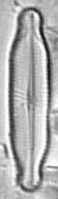

In [10]:
ref = cv2.imread("/home/souhila/nvme-storage/ATLAS/RA_V3/ABRY/RA_ABRY_0001.png", cv2.IMREAD_GRAYSCALE)
display(Image.fromarray(ref))
str_id = '{:04d}'.format(n_id)
diatom_images_train, diatom_images_val = split_img_list(list_images(DATASET_PATH, diatoms=True, ref=ref), PERCENTAGE_VAL)
debris_images_train, debris_images_val = split_img_list(list_images(DATASET_DUST_PATH, diatoms=False, ref=ref), PERCENTAGE_VAL)


In [32]:
DATASET_PATH = ["/mnt/nvme-storage/pfauregi/datasets/atlas/BRG/"]
DATASET_DUST_PATH = ["/mnt/nvme-storage/pfauregi/datasets/debris/"]
PERCENTAGE_VAL = 0.1
n_id=0

In [136]:
from random import*
ind=[]
a=[]
for i in range(int(len(images_path)/6)):
    ind.append(i*6+randint(0,5))



In [137]:
ind

[0, 7, 13, 23, 27, 33, 38]

In [143]:
a=[]
for k in range(6):
    for j in range(7):
        if ind[j]in[5,11,17,23,29,35,41]:
            ind[j] = ind[j]
        else: ind[j] +=1 
        

42 [('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_0.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DMON', 'Diatoms_DMON_10378_0.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/AUPU', 'Diatoms_AUPU_058018_1.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/PTDE', 'Diatoms_PTDE_019013_5.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/SIDE', 'Diatoms_SIDE_1233_2.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/NCPR', 'Diatoms_NCPR_086005_2.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/RUNI', 'Diatoms_RUNI_020030_3.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_0.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DMON', 'Diatoms_DMON_10378_0.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/AUPU', 'Diatoms_AUPU_058018_1.png'), ('/mnt/nvme-storage/souhila/data/artificial/tmp_arti

In [55]:
diatoms =True
i = 0
images_path = []
data_path = DATASET_PATH
for path in data_path:
    for root, dirs, files in os.walk(path):
        for file in files:
            #print(file,root)
            if file.split(".")[1] in ["png", "tif", "tiff", "TIF", "PNG"]:
                images_path.append((root, file))
                i+=1
images_dict = {}
for image_path in images_path:
    if len(image_path[1].split('.'))>=2: 
        # defining key
        print(image_path)
        if diatoms: 
            key="diatom"
        else:
            key = "mono"
        image_path = join(image_path[0], image_path[1])
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if not ref is None:
            img = match_histograms(img, ref, multichannel=False).astype("uint8")
        img = cp.asarray(img)
        images_dict.setdefault(key,[]).append(img)
        #images_dict.setdefault(key,[]).append(image_path)
#print(i,"images found!")

('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/', '0000.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/', '0002.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/', '0001.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_1.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_2.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_0.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_4.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_3.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DCOF', 'Diatoms_DCOF_30074_5.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DMON', 'Diatoms_DMON_10378_5.png')
('/mnt/nvme-storage/souhila/data/artificial/tmp_artifical/DMON', 'Diatoms_DMON_10378_3.png')
('/mnt/nvme-storage/souhila/data/arti

In [60]:
def list_images(data_path, diatoms=True, taxon_filter=None, ref=None):
    # List all images in dataset and putting them in a dict {"key": "imgpath"}
    i = 0
    images_path = []
    for path in data_path:
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.split(".")[1] in ["png", "tif", "tiff", "TIF", "PNG"]:
                    images_path.append((root, file))
                    i+=1
    #for path in data_path: images_path.extend([(path, f) for f in listdir(path) if isfile(join(path, f))])
    #print(images_path)
    images_dict = {}
    if not taxon_filter is None: selected_taxons = get_selected_taxons()
    for image_path in images_path:
        if len(image_path[1].split('.'))>=2: 
            # defining key
            if diatoms: 
                if taxon_filter is None:
                    key="diatom"
                else:
                    key = image_path[1].split('_')[1]
                    if not key in selected_taxons:
                        key = None
            else: 
                key="mono"
            if not key is None:
                image_path = join(image_path[0], image_path[1])
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if not ref is None:
                    img = match_histograms(img, ref, multichannel=False).astype("uint8")
                img = cp.asarray(img)
                images_dict.setdefault(key,[]).append(img)
                #images_dict.setdefault(key,[]).append(image_path)
    #print(i,"images found!")
    return images_dict   
def split_img_list(dict_input, perc):
    train = {}
    val = {}
    for key in list(dict_input.keys()):
        images = dict_input[key].copy()
        np.random.shuffle(images)
        train[key], val[key] = train_test_split(images, test_size=perc, random_state=42)
    return train, val

In [58]:
split_img_list(list_images(DATASET_DUST_PATH, diatoms=False, ref=ref), PERCENTAGE_VAL)

TypeError: tuple indices must be integers or slices, not list

In [ ]:
def split_img_list(dict_input):
    
    for key in list(dict_input.keys()):
        images = dict_input[key].copy()
        np.random.shuffle(images)
        train[key], val[key] = train_test_split(images, test_size=perc, random_state=42)
    return train, val

In [29]:
from random import *
ref1 = cv2.imread("/home/souhila/nvme-storage/ATLAS/RA_V3/COCE/RA_COCE_0222.png", cv2.IMREAD_GRAYSCALE)
ref2 = cv2.imread("/home/souhila/nvme-storage/ATLAS/RA_V3/CFTF/RA_CFTF_0462.png", cv2.IMREAD_GRAYSCALE)
r = randint(0,1)
if r==0:
    ref = ref1
else: 
    ref = ref2
print(ref)

[[177 177 178 ... 174 174 173]
 [179 178 179 ... 179 176 174]
 [181 180 179 ... 180 180 180]
 ...
 [167 167 167 ... 178 177 176]
 [167 167 167 ... 178 177 176]
 [168 167 168 ... 179 178 176]]


In [51]:


from os import listdir
from os.path import isfile, join
import pickle
from IPython.display import clear_output
import PIL.Image
import multiprocessing
from lxml import etree
from sklearn.model_selection import train_test_split

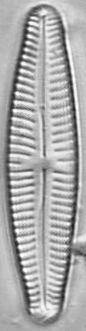

4.211560010910034 s!


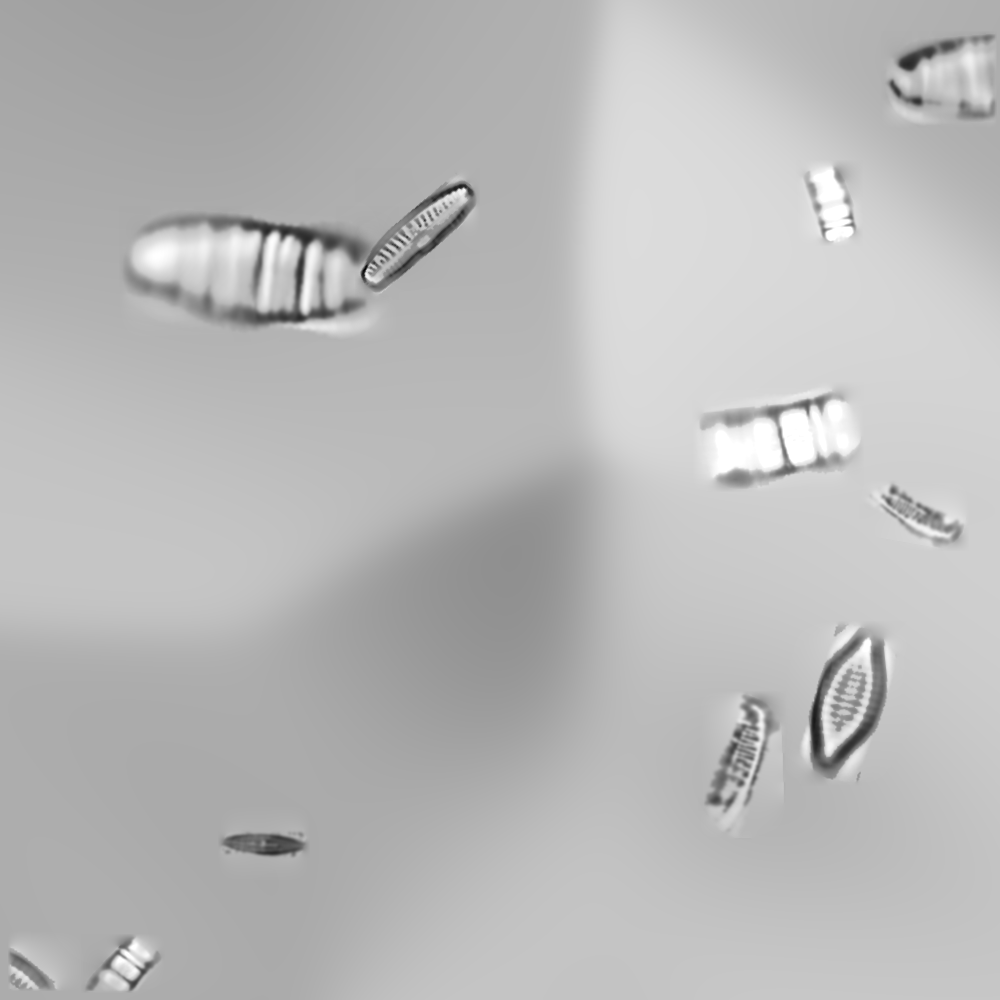

AttributeError: 'list' object has no attribute 'save'

In [53]:
from random import *
ref1 = cv2.imread("/home/souhila/nvme-storage/ATLAS/RA_V3/COCE/RA_COCE_0222.png", cv2.IMREAD_GRAYSCALE)
ref2 = cv2.imread("/home/souhila/nvme-storage/ATLAS/RA_V3/CFTF/RA_CFTF_0462.png", cv2.IMREAD_GRAYSCALE)
r = randint(0,1)
if r==0:
    ref = ref1
else: 
    ref = ref2

display(Image.fromarray(ref))
str_id = '{:04d}'.format(n_id)
                   
diatom_images_train, diatom_images_val = split_img_list(list_images(DATASET_PATH, diatoms=True, ref=ref), PERCENTAGE_VAL)
debris_images_train, debris_images_val = split_img_list(list_images(DATASET_DUST_PATH, diatoms=False, ref=ref), PERCENTAGE_VAL)
start=time.time()
np.random.seed(20)
final_image_Z = []
final_image, annotations = main_generator([diatom_images_train, debris_images_train],
                                          simple_angles = False, 
                                          size_px = 1000,
                                          verbose=False, 
                                          number_overlapping=0, 
                                          overlapping=.5, 
                                          n_diatoms=[9,12],
                                          scale_diatoms=[7,4.5],                                          
                                          n_dust=[25,40],
                                          scale_dust=[3,4])
print(time.time()-start, "s!")
display(Image.fromarray(final_image))
cv2.imwrite(os.path.join(DATASET_PATH[0] + str_id+".png"),final_image)
xml_path = os.path.join(DATASET_PATH[0] + 'annotations/' +str_id + ".xml")
annotations.save(xml_path)
n_id += 1


In [48]:
type(annotations)

list

In [42]:
def voc_writer(DATASET_PATH, img, xmin, ymin, xmax, ymax):
    # Writer(path, width, height)

    writer = Writer(os.path.join(DATASET_PATH + img + '.png'), 1000, 1000)

    # ::addObject(name, xmin, ymin, xmax, ymax)
    for objet in objets:
        writer.addObject('diatoms', xmin, ymin, xmax, ymax)

    # ::save(path)

    writer.save(os.path.join(DATASET_PATH + img + '.xml'))
